# Part 1

The following code represents a simple, inefficient pattern search that might be found during EDA in a jupyter notebook.

In a separate `.py` file, refactor this code using OOP to make it more extensible and efficient.

Your object should be able to do each of the following:

1. Accept either a string or a list of words as input text to be searched for pattern matches (if a string is passed, only words in the string that match the pattern should be caught)
2. Allow for registering an arbitrary number of pattern groups to search input text
3. Allow the user to specify a specific pattern group to search the text for matches
4. Allow the user to search input text with all registered patterns and return all matches by pattern group

In [1]:
my_words = ['dog', 'cat', 'mouse', 'bird', 'snake', 'kitten', 'puppy']

pattern_1_words = []
pattern_2_words = []

pattern_group_1 = [
	'at',
	'ou'
]

pattern_group_2 = [
	'in',
	'mo'
]

for word in my_words:
	for pat in pattern_group_1:
		if pat in word:
			pattern_1_words.append(word)
for word in my_words:
	for pat in pattern_group_2:
		if pat in word:
			pattern_2_words.append(word)

print(f"Pattern 1: {pattern_1_words}")
print(f"Pattern 2: {pattern_2_words}")

Pattern 1: ['cat', 'mouse']
Pattern 2: ['mouse']


\#########################################################

### Note: The .py file created is main.py and can be found on this repository: https://github.com/nicolascarva/Recycling-Partnership-Takehome.git

Instructions for running it:

1. Instantiate object with text to be searched (string or list) as input:
`input = Match ('example text')`

2. Add desired pattern groups by running add_patterns method and using a dictionary with the pattern name as key and a list of the patterns as values. More pattern groups can be added as desired.

`pattern_groups1 = {'pat_1': ['ex', 'am'], 'pat_2': ['xt']}
pattern_groups2 = {'pat_3': ['foo']}
input.add_patterns(pattern_groups1)
input.add_patterns(pattern_groups2)`

3. To find matches run the match_patterns method with a list of the names of the desired pattern groups as input (if empty, default is all):

`input.match_patterns(['pat_1'])`

4. If new text needs to be searched, a new object may be instantiated, or, to avoid having to add patterns again, run the change_text method with new text (string or list) as the input:

`input.change_text(['new', 'text'])`


\############################################################

# Part 2

Writes tests for your code using `pytest`

#### To run test clone the repository and run 
`python -m pytest` in the environment. Test can be found in the `test_class.py` file.

# Part 3

Imagine your job is to help build the text processing pipeline for a machine learning model. This model takes strings, processes them into vectors, and then classifies the text as relating to one of several categories (a multiclass classifier).

The raw data that is passed into the machine learning pipeline has strings that may include descriptions of many items, including multiple items that we are seeking to classify, as well as descriptions of items that are irrelevant to our classifier. These must be separated before being passed to classifier.

As the newest member of the team, your job is to get up to speed with the data as quickly as possible, and to find opportunities to improve the text processing pipeline. Perform an EDA on the following CSV to accomplish this. Be prepared to explain what insights you learned from the data, and what approaches you might use to improve the pipeline.

Perform the analysis in this notebook, below this prompt.

# Analysis

In [2]:
## Imports ##
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

import spacy

import gensim
import gensim.corpora as corpora

import pyLDAvis
import pyLDAvis.gensim_models

In [3]:
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


First we'll import the csv data and take a look at it.

In [4]:
df = pd.read_csv('./data/takehome.csv', index_col='id')
pd.set_option('display.max_colwidth', 32)
df.head()

,text,added_datetime,yes_no,image_coordinates,image_url,original_id,page_number,parser_version,model_version,manual_override
id,,,,,,,,,,
462548,No plastic bags or pesticide...,2021-07-13 01:18:01.983,no,{'originalSize': {'height': ...,NaN,NaN,NaN,NaN,NaN,NaN
462549,No paint or aerosol cans .,2021-07-13 01:18:01.983,no,{'originalSize': {'height': ...,NaN,NaN,NaN,NaN,NaN,NaN
462550,Tin and aluminum food and dr...,2021-07-13 01:18:01.983,yes,{'originalSize': {'height': ...,NaN,NaN,NaN,NaN,NaN,NaN
462551,Corrugated and non corrugate...,2021-07-13 01:18:01.983,yes,{'originalSize': {'height': ...,NaN,NaN,NaN,NaN,NaN,NaN
462552,Includes all colors office p...,2021-07-13 01:18:01.983,yes,{'originalSize': {'height': ...,NaN,NaN,NaN,NaN,NaN,NaN


There's not a lot of context in the data and many of the columns seem to be mainly null (below). There is a yes/no column that seems to be correlated to the text, my initial assumption is that it describes if the text specifies a material (YES) or excludes a material (NO). So we'll keep the index column, the text column and the yes_no column. The rest of the columns need more information or context, so we'll leave them out of the analysis for now.

We check for null in the text column and drop those rows as well as the rows that won't be analyzed.

In [5]:
df.isnull().sum()

text                    3
added_datetime          0
yes_no                  0
image_coordinates     660
image_url            1000
original_id          1000
page_number          1000
parser_version        340
model_version         340
manual_override       340
dtype: int64

In [6]:
df = df[['text', 'yes_no']]
df.dropna(subset=['text'], inplace=True)
df.isnull().sum()

text      0
yes_no    0
dtype: int64

In [7]:
df.shape

(997, 2)

In [8]:
df.head()

,text,yes_no
id,,
462548,No plastic bags or pesticide...,no
462549,No paint or aerosol cans .,no
462550,Tin and aluminum food and dr...,yes
462551,Corrugated and non corrugate...,yes
462552,Includes all colors office p...,yes


Now we are going to clean the text to remove unwanted characters and be able to compare word counts and do other data manipulation.

In [9]:
def clean_text(text):
    """
    Accepts a single text document and performs several regex
    substitutions in order to clean the document.
    Parameters
    ----------
    text: string
    Returns
    -------
    text: list of words
    """
    special_chars_regex = '[:?,.>$|!\'"]'
    white_spaces_regex = '[ ]{2,}'
    text = re.sub('[^a-zA-Z ]', " ", text)
    text = re.sub(special_chars_regex, " ", text)
    text = re.sub(white_spaces_regex, " ", text)
    return text

In [10]:
df['text'] = [clean_text(text) for text in df['text']]


Let's look at how many words each row contains. Makes sense that there would be a correlation between the number of materials in the classification and the number of words in the text. We'll add that data as a column and plot the histogram. We can see that the vast majority of text is under 10 words. Maybe this would be useful in the future (ie. applying different models, or manually reviewing rows with the long text).

(array([  2., 159., 196.,  71.,  62., 238.,  34.,  34.,  19.,  17.,  12.,
         12.,  11.,  12.,   7.,  10.,   7.,   9.,   4.,   8.,   6.,   5.,
          3.,   2.,   1.,   2.,   3.,   0.,   9.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <BarContainer object of 29 artists>)

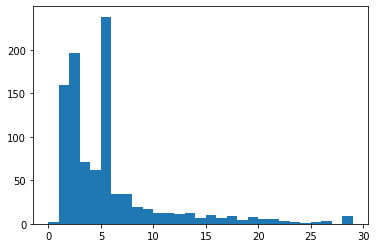

In [11]:
df['num_of_words'] = [len(text.split()) for text in df['text']]
plt.hist(df['num_of_words'],bins=range(30))

We are going to plot the most common words in a histogram by creating a Document Term Matrix with sklearn and then counting the word frequencies. We are using unigrams and bigrams for the analysis.

In [12]:
cv = CountVectorizer(stop_words='english', ngram_range=[1,2]) 
cv_matrix = cv.fit_transform(df['text']) 
# create document term matrix
df_dtm = pd.DataFrame(cv_matrix.toarray(), columns=cv.get_feature_names_out())

<BarContainer object of 10 artists>

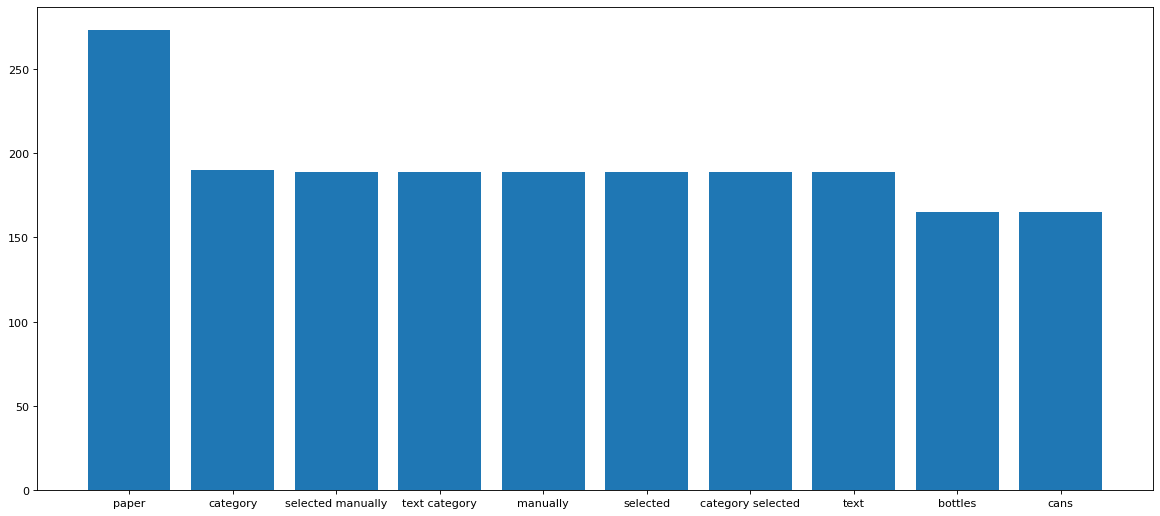

In [13]:
word_count = pd.DataFrame(index=cv.get_feature_names_out(), data=[df_dtm[feature].sum() for feature in cv.get_feature_names_out()], 
             columns=['count']).sort_values(by=['count'], axis=0, ascending=False)
plt.figure(figsize=(18, 8), dpi=80)
plt.bar(word_count[:10].index, word_count['count'][:10])

We find that 'category', 'selected manually', etc. are a large part of the word count, which is odd so we look at the rows that contain 'category':

In [14]:
[(index, text) for (index, text) in zip(df.index, df['text']) if 'category' in text]

[(462634,
  'Mixed Paper This category includes all other paper such as notebook paper Post it notes colored copy paper computer paper and white copy paper white envelopes green bar or blue bar computer paper junk mail etc Staples are OK '),
 (280510, 'No text category selected manually'),
 (280512, 'No text category selected manually'),
 (280573, 'No text category selected manually'),
 (306757, 'No text category selected manually'),
 (310641, 'No text category selected manually'),
 (280536, 'No text category selected manually'),
 (280537, 'No text category selected manually'),
 (280538, 'No text category selected manually'),
 (280539, 'No text category selected manually'),
 (280540, 'No text category selected manually'),
 (280541, 'No text category selected manually'),
 (280542, 'No text category selected manually'),
 (280543, 'No text category selected manually'),
 (280544, 'No text category selected manually'),
 (280545, 'No text category selected manually'),
 (280546, 'No text cate

We find there's quite a bit of rows with 'No text category selected manually' as their only data. With more context, this data could prove useful, but for now we'll drop these rows and re-run the analysis.

In [15]:
df = df[df['text'] != 'No text category selected manually']
df.shape

(808, 3)

Re-running the analysis, it looks as expected, the most frequent words are for objects or materials that are recyclable.

<BarContainer object of 20 artists>

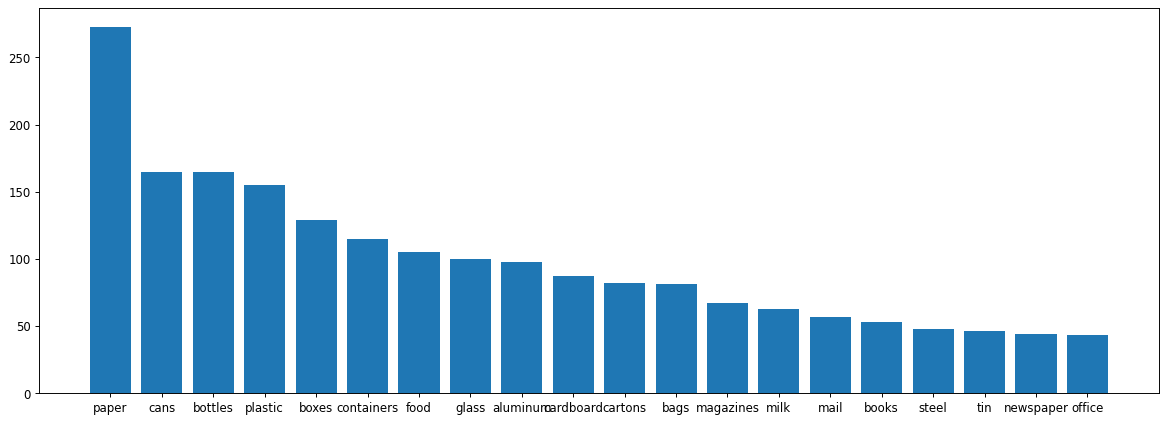

In [16]:
cv = CountVectorizer(stop_words='english') 
cv_matrix = cv.fit_transform(df['text']) 
# create document term matrix
df_dtm = pd.DataFrame(cv_matrix.toarray(), columns=cv.get_feature_names_out())
#Word count
word_count = pd.DataFrame(index=cv.get_feature_names_out(), data=[df_dtm[feature].sum() for feature in cv.get_feature_names_out()], 
             columns=['count']).sort_values(by=['count'], axis=0, ascending=False)
plt.figure(figsize=(17, 6), dpi=85)
plt.bar(word_count[:20].index, word_count['count'][:20])

We'll also run the word count per row again:

(array([  2., 159., 196.,  71.,  62.,  49.,  34.,  34.,  19.,  17.,  12.,
         12.,  11.,  12.,   7.,  10.,   7.,   9.,   4.,   8.,   6.,   5.,
          3.,   2.,   1.,   2.,   3.,   0.,   9.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <BarContainer object of 29 artists>)

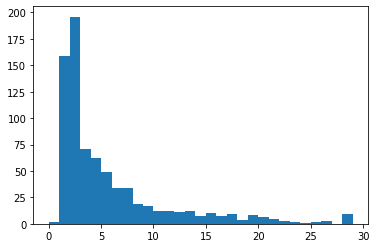

In [17]:
plt.hist(df['num_of_words'],bins=range(30))

Let's take a look at the rows with over 25 words:

In [18]:
pd.set_option('display.max_colwidth', 150)
df[df['num_of_words'] > 15].head()
df[df['num_of_words'] > 15].head()

,text,yes_no,num_of_words
id,,,
462563,Plastics such as those from Cleaners Food containers Bleach Milk Cooking oils Pill bottles Cosmetics lotions Shampoo conditioner Soft drinks Deter...,yes,26
462564,Catalogs Cereal boxes Shredded paper Mail Toilet paper rolls Frozen food boxes Greeting cards Boxboard e g pop boxes,yes,19
462565,Office paper white and colored Phonebooks Corrugated cardboard Tissue boxes Snack boxes Pop and beer cartons Wrapping paper tubes Paper gift shopp...,yes,30
462566,Newspaper advertisements Magazines Shoe boxes Paperback books Paper egg cartons Paper towel rolls Tissue paper Kraft paper bags Gable Top Containe...,yes,26
462567,Aluminum and metal cans foil and foil trays lids and aerosol spray cans must be empty Please,yes,17


#### We'll separate the yes and no rows in two different dataframes.

In [19]:
df_yes = df.loc[df['yes_no'] == 'yes']
df_no = df.loc[df['yes_no'] == 'no']

In [20]:
print(df_yes.shape)
print(df_no.shape)


(681, 3)
(127, 3)


Let's run the word-count analysis for df_no, it'd be interesting to see what is being excluded. 

In [21]:
df_no.head(25)

,text,yes_no,num_of_words
id,,,
462548,No plastic bags or pesticide containers,no,6
462549,No paint or aerosol cans,no,5
462555,Broken glass,no,2
462556,Aerosol cans Gas cans,no,4
462557,Mirror window glass crystal drinking glass ceramics ovenware light bulbs,no,10
462558,Gift wrap,no,2
462559,Plastic grocery bags,no,3
462560,Styrofoam,no,1
462571,Shingles Ashes Chemicals Yard Waste Railroad Ties Concrete Brick Rock Dirt Large Metal Objects such as Cars Machinery Livestock Feeders Fencing etc,no,22


As expected, many of the most common words are of non-recyclable materials (food, waste, oil, etc.), there are some recyclable materials (plastic bags) in the list, which probably means they go in a different bin.

In [22]:
cv = CountVectorizer(stop_words='english', ngram_range=[1,2]) 
cv_matrix = cv.fit_transform(df_no['text']) 
# create document term matrix
df_dtm = pd.DataFrame(cv_matrix.toarray(), columns=cv.get_feature_names_out())

<BarContainer object of 20 artists>

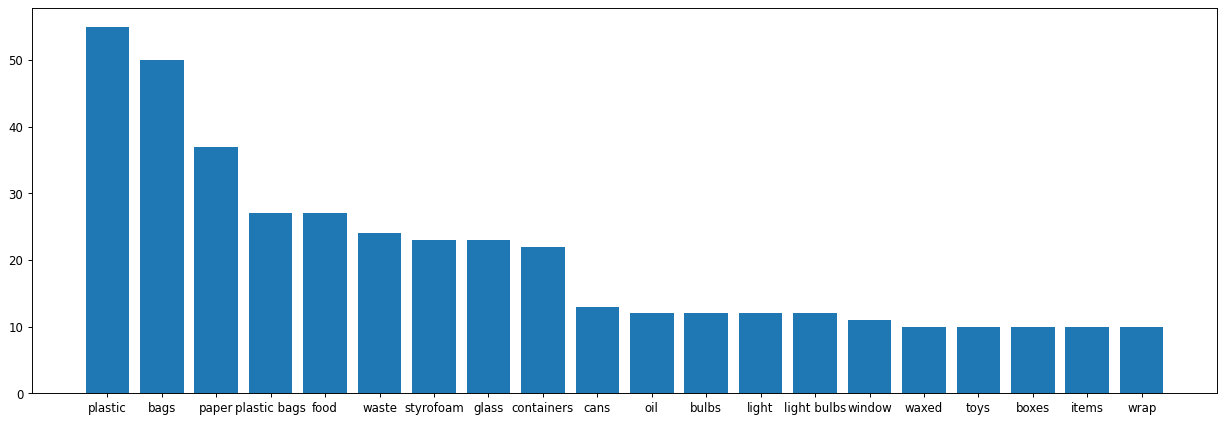

In [23]:
word_count = pd.DataFrame(index=cv.get_feature_names_out(), data=[df_dtm[feature].sum() for feature in cv.get_feature_names_out()], 
             columns=['count']).sort_values(by=['count'], axis=0, ascending=False)
plt.figure(figsize=(18, 6), dpi=85)
plt.bar(word_count[:20].index, word_count['count'][:20])

In [24]:
word_count[word_count.index.str.contains(' ')][:10]

,count
plastic bags,27
light bulbs,12
window glass,8
food waste,8
motor oil,6
waxed paper,6
wrapping paper,5
bags plastic,5
aerosol cans,5
pizza boxes,5


# LDA

We'll apply LDA to df_yes and df_no separately to see which words tend to appear together on each.

In [33]:
def tokenize(doc):
# run the clean_data function on the text
    text = clean_text(doc)
# Instantiatie language model
    doc = nlp(text)
    STOP_WORDS = nlp.Defaults.stop_words.union('', 'the', 'this', '-pron-', 'no ', 'non' )
    return [token.lemma_.lower().lstrip().rstrip() for token in doc 
            if (token.text not in STOP_WORDS) 
            and (token.is_punct != True)
            and (token.text not in '')
            and (len(token.text)>1)]

In [52]:
def apply_lda(df):
    # prepare data for LDA model
    lemmas = [tokenize(text) for text in df['text'] ]
    #Prepare bag of words
    id2words = corpora.Dictionary(lemmas)
    corpus = [id2words.doc2bow(lemma) for lemma in lemmas]
    # prepare model
    lda_multicore = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2words,
                                                        num_topics=4,
                                                        chunksize=10,
                                                        passes=100,
                                                        per_word_topics=True,
                                                        workers=6)


## df_yes LDA

In [53]:
apply_lda(df_yes)

In [54]:
# run visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_multicore, corpus, id2words)
vis

c:\users\ncarv\.virtualenvs\recycling-partnership-takehome-7fp9ueh8\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.086768  0.149531       1        1  42.143724
1     -0.196257 -0.053896       2        1  28.082280
2      0.212070  0.065072       3        1  19.366525
3      0.070954 -0.160707       4        1  10.407471, topic_info=          Term        Freq       Total Category  logprob  loglift
21       paper  215.000000  215.000000  Default  30.0000  30.0000
68   cardboard   64.000000   64.000000  Default  29.0000  29.0000
1          can  108.000000  108.000000  Default  28.0000  28.0000
19   newspaper   54.000000   54.000000  Default  27.0000  27.0000
0     aluminum   93.000000   93.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
0     aluminum    3.124728   93.018637   Topic4  -4.8736  -1.1308
119    bottles    2.029489   16.187216   Topic4  -5.3052   0.1862
93         lid    2.018656   29.940932   Topic4  -5.3106  -0.4341
5          box    1.962578  107.316588   Topic4  -5.3387  -1.7389
132       item    1.592893   11.427294   Topic4  -5.5474   0.2922

[229 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
210       1  0.610514   accept
210       2  0.076314   accept
210       4  0.228943   accept
92        3  0.216085  aerosol
92        4  0.756297  aerosol
...     ...       ...      ...
121       4  0.647994      wet
78        1  0.343134    white
78        2  0.629079    white
538       2  0.736800   yellow
114       1  0.960824   yogurt

[294 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

## df_no LDA

In [47]:
apply_lda(df_no)

c:\users\ncarv\.virtualenvs\recycling-partnership-takehome-7fp9ueh8\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [48]:
# run visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_multicore, corpus, id2words)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.086768  0.149531       1        1  42.143203
1     -0.196257 -0.053896       2        1  28.082363
2      0.212070  0.065072       3        1  19.366992
3      0.070954 -0.160707       4        1  10.407443, topic_info=          Term        Freq       Total Category  logprob  loglift
21       paper  215.000000  215.000000  Default  30.0000  30.0000
68   cardboard   64.000000   64.000000  Default  29.0000  29.0000
1          can  108.000000  108.000000  Default  28.0000  28.0000
19   newspaper   54.000000   54.000000  Default  27.0000  27.0000
0     aluminum   93.000000   93.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
0     aluminum    3.124720   93.020225   Topic4  -4.8736  -1.1308
119    bottles    2.029483   16.187341   Topic4  -5.3052   0.1862
93         lid    2.018650   29.940696   Topic4  -5.3106  -0.4341
5          box    1.962573  107.316047   Topic4  -5.3387  -1.7389
132       item    1.592889   11.427271   Topic4  -5.5474   0.2922

[229 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
210       1  0.610519   accept
210       2  0.076315   accept
210       4  0.228944   accept
92        3  0.216084  aerosol
92        4  0.756295  aerosol
...     ...       ...      ...
121       4  0.647994      wet
78        1  0.343134    white
78        2  0.629080    white
538       2  0.736798   yellow
114       1  0.960834   yogurt

[294 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])